# INSIGHTS

As anotações e documentação dos testes estão no Maxtrade


#### Bibliotecas

In [1]:
# BASIC
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import joblib

# CLASSIFIER
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

#REGRESSOR
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

# PRE-PROCESSING
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#METRICS
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score


# STATISTIC
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# DATA VIZ
import matplotlib.pyplot as plt
import seaborn as sns

# WARNING
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [94]:
# EURUSD IQ - 10/04/2023 - fonte: iqoption : laranja_captura_velas.py
import shutil
import time
import os
from glob import glob

files = sorted(glob('C:/_PY/Trade_NB/IQOPTION/*.csv'))
latest_file = max(files, key=os.path.getctime)
print(latest_file)

colunas = ['Time', 'Open', 'Low', 'High', 'Close', 'Volume', 'At', 'To']
#df_base = pd.read_csv(r'C:\_PY\Trade_NB\IQOPTION\export_candlesEURUSD_2023-04-11 05-21-06.csv', sep=';')
df_base = pd.read_csv(latest_file, sep=';')
df_base.columns = colunas
df_base['Time'] = pd.to_datetime(df_base['Time'], utc=True)
df_base.set_index('Time', inplace=True)

df_base = df_base[['Open', 'High', 'Low', 'Close', 'Volume']]
df_base['Adj Close'] = df_base['Close']
# conferindo o tamanho do dataset

print('EURUSD IQ tamanho:', df_base.shape)


C:/_PY/Trade_NB/IQOPTION\export_candlesEURUSD_2023-04-11 05-21-06.csv
EURUSD IQ tamanho: (1800, 6)


### OUTLIERS

### Serie Estacionaria

In [38]:
# Agora, vamos analisar se a série é estacionária, ou não. Para que seja, ela precisa ter a média e a variância constantes no tempo, além de ter correlação entre 2 períodos constante

# Vamos utilizar o teste de Dickey Fuller para verificar se nossa série é estacionária ou não.
# H0 -> Série não estacionária (p-value > 0.05)
# H1 -> Série estacionária (p-value <= 0.05)

# o resultado estatístico mostrou que a série não é estacionária. (p-value > 0.05)
#Então, vamos utilizar a técnica de diferenciação para tornar a série estacionária, para podermos aplicar o modelo ARIMA

adfuller_aapl_hora = adfuller(df_base['Adj Close'])
print('ADF Statistics:', adfuller_aapl_hora[0])
print('p-value :', adfuller_aapl_hora[1])

ADF Statistics: -1.194608624863361
p-value : 0.6759106346699157


In [39]:
# Calculo do retorno percentual (1º diferenciação)
df_arima = df_base.copy()
df_arima['return_percent'] = df_arima['Adj Close'].pct_change()
df_arima.dropna(inplace=True)

In [40]:
# apenas checagem

# rodando o método de Dickey Fuller para retorno PERCENTUAL
adfuller_df_arima = adfuller(df_arima['return_percent'])
print('ADF Statistics AAPL HORA:', adfuller_df_arima[0])
print('p-value AAPL HORA:', adfuller_df_arima[1])

ADF Statistics AAPL HORA: -10.635147867745783
p-value AAPL HORA: 5.094912722671977e-19


In [41]:
# TIMEFRAME
#BASE MINUTOS DIARIO 510 
#BASE HORAS POR PREGAO DIARIO: 7
#BASE MESES PREGAO ANO: 12

time_frame = 7

In [42]:
# https://maxwellpaparelli.medium.com/time-series-s%C3%A9ries-temporais-com-python-f4e74fd45b0b
df_log = np.log(df_base)
ma_log = df_log.rolling(time_frame).mean()

#subtrair média do log dos dados, iremos fazer a média em 12, pois iremos fazer anualmente
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(time_frame).mean()
#desvio padrão
std_sub = df_sub.rolling(time_frame).std()

In [43]:
# apenas checagem

adfuller_df_arima = adfuller(df_log['Adj Close'])
print('ADF Statistics AAPL HORA:', adfuller_df_arima[0])
print('p-value AAPL HORA:', adfuller_df_arima[1])

ADF Statistics AAPL HORA: -1.1950073947003166
p-value AAPL HORA: 0.6757397087183676


In [44]:
# apenas checagem

#repetir o ADF
X_sub = df_sub['Adj Close'].values

# aplicar ADF e imprimir o resultado
result_sub = adfuller(X_sub)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_sub[0]))
print('Valor-p: {:.10f}'.format(result_sub[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -10.2687
Valor-p: 0.0000000000
Valores Críticos:
	1%: -3.4340
	5%: -2.8632
	10%: -2.5676


Dickey-Fuller Aumentado
Teste Estatístico: -12.2503
Valor-p: 0.0000000000
Valores Críticos:
	1%: -3.4340
	5%: -2.8632
	10%: -2.5676


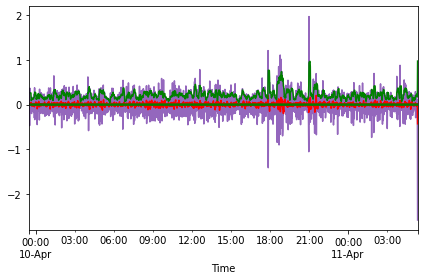

In [45]:
#Diferenciação

#aplicar diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(time_frame).mean()
#desvio padrão
std_diff = df_diff.rolling(time_frame).std()

#plotar a diferenciação
fig, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

#extrair apenas os valores e retirar os valores NA
X = df_diff['Adj Close'].dropna().values

# aplicar ADF e imprimir o resultado
result_diff = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_diff[0]))
print('Valor-p: {:.10f}'.format(result_diff[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

In [46]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1794 entries, 2023-04-09 23:28:00+00:00 to 2023-04-11 05:21:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1793 non-null   float64
 1   High       1793 non-null   float64
 2   Low        1793 non-null   float64
 3   Close      1793 non-null   float64
 4   Volume     1793 non-null   float64
 5   Adj Close  1793 non-null   float64
dtypes: float64(6)
memory usage: 98.1 KB


In [47]:
df_diff = df_diff.dropna()

In [48]:
df_diff['return_percent'] = df_diff['Adj Close'].pct_change()

### Teste de Normalidade

In [49]:
#Agora, podemos verificar se as distribuições de retorno são normais ou não.

#Para isso, vamos utilizar o método de shapiro, da lib scipy stats
print('Dataset HORAS, retorno PERCENTUAL (1º dif.):', stats.shapiro(df_diff['return_percent']))

Dataset HORAS, retorno PERCENTUAL (1º dif.): ShapiroResult(statistic=nan, pvalue=1.0)


In [50]:
m_df = df_diff.copy()

### Variaveis Vinny

In [51]:
#-----------------------------------FEATURE ENGINEERING--------------------------------------------

In [52]:
# CRIANDO FEATURE RSI
def criar_rsi(df):
    n = 20
    def rma(x, n, y0):
        a = (n-1) / n
        ak = a**np.arange(len(x)-1, -1, -1)
        return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]

    df['change'] = df['Adj Close'].diff()
    df['gain'] = df.change.mask(df.change < 0, 0.0)
    df['loss'] = -df.change.mask(df.change > 0, -0.0)
    df['avg_gain'] = rma(df.gain[n+1:].to_numpy(), n, np.nansum(df.gain.to_numpy()[:n+1])/n)
    df['avg_loss'] = rma(df.loss[n+1:].to_numpy(), n, np.nansum(df.loss.to_numpy()[:n+1])/n)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1 + df.rs))
    return df

In [53]:
# CRIANDO FEATURE BOLLINGER BAND
def criar_bollinger(df):
  # calculando a média móvel e limites superior e inferiror
  # limites com base em 2 desvios padrão
  mid = df['Adj Close'].rolling(20).mean()
  std = df['Adj Close'].rolling(20).std()
  up = mid + std
  low = mid - std

  # criando features para a média e os limites
  df['upper'] = up
  df['mid'] = mid
  df['low'] = low
  df['bbp'] = (df['Adj Close'] - df['low'])/(df['upper'] - df['low'])
  df.dropna(inplace=True)
  return df

In [54]:
# RESISTÊNCIA
def is_resistance(df,i):
  resistance = (df['High'][i] > df['High'][i-1]
                and df['High'][i] > df['High'][i+1]
                and df['High'][i+1] > df['High'][i+2]
                and df['High'][i-1] > df['High'][i-2])
  return resistance

# SUPORTE
def is_support(df,i):
  support = (df['Low'][i] < df['Low'][i-1]
             and df['Low'][i] < df['Low'][i+1]
             and df['Low'][i+1] < df['Low'][i+2]
             and df['Low'][i-1] < df['Low'][i-2])
  return support

def suporte_resistencia(df):
  # resistência verdadeiro -> 1 (vender)
  # suporte verdadeiro -> 0 (comprar)
  # outros (2)

  # criando feature com valores 2
  df['suport_resistencia'] = 2

  # definindo os valores 1 e 0
  for i in range(2, df.shape[0] - 2):
    if is_resistance(df,i):
      df['suport_resistencia'][i] = 1 # definindo 1 para resistência
    elif is_support(df,i):
      df['suport_resistencia'][i] = 0 # definindo 0 para suporte
  return df

In [55]:
# LTA E LTB
# 0.5 são classificadas como tendência de alta, menos que -0.5 são tendência de baixa
def lta_ltb(df):
  df2 = df.reset_index()
  df['corr'] = (df2['Adj Close'].rolling(20).corr(pd.Series(df2.index))).tolist()
  df.dropna(inplace=True)

  def condition(x):
      if x<=-0.5:
          return -1
      elif x>-0.5 and x<0.5:
          return 0
      else:
          return 1
  df['corr_class'] = df['corr'].apply(condition)

  return df

In [56]:
# MÉDIA MÓVEL
def media_movel(df, coluna, defasagem):
  df['media_movel'] = df[coluna].rolling(20).mean()
  return df

In [57]:
# FEATURES DE TEMPO
def feat_temporais(df):
  df['dia_semana'] = df.index.dayofweek
  df['horario'] = df.index.hour
  df['mes'] = df.index.month
  return df

In [58]:
# CRIANDO A TARGET
def target(df):

  # criando feature com 1h de defasagem (com hora anterior)
  df['def_1'] = df['Adj Close'].shift(1)
  # criando feature comparando valor atual com o defasado
  df['subt'] = df['Adj Close'] - df['def_1']
#  criando a target de subida ou descida do valor da ação
#  0 -> caiu (com relação ao anterior)
#  1 -> subiu (com relação ao anterior)
#  2 -> igual ao anterior
  
  df['target'] = df['subt'].apply(lambda x: int(0) if x<0 else int(1) if x>0 else int(2))
  #df['target'] = df['subt'].apply(lambda x: int(0) if x<=0 else int(1))
  return df


In [59]:
# FEATURES DEFASADAS 
def constroi_features_defasadas(df,lista_features,defasagem_maxima):
    # Constrói features defasadas com base na base original
    # Copia a base
    df_cop = df.copy()
    for feat in lista_features:       
        for i in range(1,defasagem_maxima+1):
            df_cop[str(feat)+'_def_'+str(i)] = df_cop[feat].shift(i)
    
    df_cop.dropna(inplace=True)
    return df_cop

In [60]:
# FEATURES FUTURAS
def constroi_features_futuras(df,feature,defasagem):
    # Constrói features defasadas com base na base original
    # Copia a base
    df_cop = df.copy()

    df_cop[str(feature)+'_fut'] = df_cop[feature].shift(-defasagem)
    return df_cop

In [61]:
m_df = criar_rsi(m_df) # 'change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi'
m_df = criar_bollinger(m_df) #'upper', 'mid', 'low','bbp'
m_df = suporte_resistencia(m_df) #'suport_resistencia'
m_df = lta_ltb(m_df) # 'corr', 'corr_class'
m_df = media_movel(m_df, 'Adj Close', 20) # 'media_movel'
m_df = feat_temporais(m_df) # 'dia_semana', 'horario', 'mes'

In [62]:
###-----------------------------------FUNÇÃO DO MODELO-------------------------------------------- '''

In [63]:
def modelo(df, target_):
    X_test = df.drop(target_, axis=1)[-1:]

    X_train = df[:-1].dropna().drop(target_, axis=1)
    y_train = df[:-1].dropna()[target_]

    xgb = XGBClassifier(random_state=42,
			gamma = 0.1,
			max_depth = 8,
			n_estimators = 100,
			n_jobs=-1)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    y_proba = xgb.predict_proba(X_test)
    y_proba = y_proba[:, 1]
    return y_pred, y_proba

In [64]:
def preprocessamento(base, corte_treino_teste,target):
  # separando a base da target
  X = base.drop(target, axis=1)
  y = base[target]
  # cortando em treino e teste
  X_train = X[X.index<=corte_treino_teste]
  X_test = X[X.index>corte_treino_teste]
  y_train = y[y.index<=corte_treino_teste]
  y_test = y[y.index>corte_treino_teste]
  return X_train, X_test, y_train, y_test

In [65]:
modelos_candidatos = {'Árvore':DecisionTreeClassifier(random_state=42),
                      'RandomForest':RandomForestClassifier(random_state=42),
                      'XGBoost':XGBClassifier(random_state=42)
                     }
def avaliacao_modelos(modelos,X_train,y_train):
  avaliacao = {}
  scores = []
  ts = TimeSeriesSplit(n_splits=5).split(X_train,y_train)
  for nome,model in modelos_candidatos.items():
    # Avalia a crossvalidação
    score = cross_val_score(model, # Escolhendo o nosso modelo da vez
                          X_train, y_train, # Nossos dados, excluindo o teste
                          cv=TimeSeriesSplit(n_splits=5).split(X_train,y_train), # Validação cruzada temporal
                          scoring='accuracy', # Usando a acurácia como métrica
                          ).mean() # Tirando a média de todos os folds
    avaliacao[nome] = score
    scores.append(score)
  
  return avaliacao, scores

In [66]:
##-----------------------------------CRIANDO DATASET-------------------------------------------- '''
hora_previsao = 1
m_df = target(m_df)
m_df.dropna(inplace=True) #, 'bbp', 'corr_class'
#m_df = m_df[['bbp', 'corr_class','amplitude','body','pavil_call', 'pavil_put', 'retorno_volume', 'retorno','target', 'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
m_df = m_df[['bbp', 'corr_class','target', 'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
m_df = constroi_features_defasadas(m_df,['Adj Close'],20)
m_df = constroi_features_futuras(m_df,'target',hora_previsao)
m_df_model = m_df.drop('target', axis=1)

### Normalização

In [67]:
scaler = MinMaxScaler()#StandardScaler() #MinMaxScaler()

### Treino Teste

In [68]:
m_df = m_df.dropna()

##### tradicional

##### exemplo do Mario

##### exemplo do Andre

In [69]:
m_df = m_df.loc[:,['bbp','corr_class', 'target', 
        'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana',
       'horario', 'mes', 'Adj Close_def_1', 'Adj Close_def_2',
       'Adj Close_def_3', 'Adj Close_def_4', 'Adj Close_def_5',
       'Adj Close_def_6', 'Adj Close_def_7', 'Adj Close_def_8',
       'Adj Close_def_9', 'Adj Close_def_10', 'Adj Close_def_11',
       'Adj Close_def_12', 'Adj Close_def_13', 'Adj Close_def_14',
       'Adj Close_def_15', 'Adj Close_def_16', 'Adj Close_def_17',
       'Adj Close_def_18', 'Adj Close_def_19', 'Adj Close_def_20','target_fut']]

In [70]:
x_train, x_test, y_train, y_test = preprocessamento(m_df, m_df.index[round(len(m_df.index) * 0.8)], 'target_fut')

x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

##### MODELOS CANDIDATOS - ANDRÉ

In [71]:
avaliacao_modelos(modelos_candidatos, x_train, y_train)

({'Árvore': 0.6333333333333333,
  'RandomForest': 0.7578947368421052,
  'XGBoost': 0.7421052631578947},
 [0.6333333333333333, 0.7578947368421052, 0.7421052631578947])

#### Testando o modelo campeao

In [62]:
# BUGADO - Input cotains NaNs

base_cop = m_df.copy()
base_cop = constroi_features_futuras(base_cop,'target',1)
base_cop.drop('target', axis=1, inplace=True)
X1_train, X1_test, y1_train, y1_test = preprocessamento(base_cop, base_cop.index[round(len(base_cop.index) * 0.8)], 'target_fut')
# criando df de resultados
result = pd.DataFrame()
# fitando o modelo
xgb = XGBClassifier(random_state=42,max_depth=5)
xgb.fit(X1_train, y1_train)
y1_pred = xgb.predict(X1_test)
y1_proba = xgb.predict_proba(X1_test)
y1_proba = y1_proba[:, 1]
# criando as colunas de resultados
result['y1_test'] = y1_test
result['y1_predict'] = y1_pred
result['proba'] = y1_proba
"""
print(metrics.classification_report(y1_test, y1_pred))
# criando a matriz de confusão
ax = sns.heatmap(metrics.confusion_matrix(y1_test, y1_pred),
                 annot=True,
                 annot_kws={"fontsize":10},
                 fmt = 'd',
                 cmap = 'Blues')
"""

'\nprint(metrics.classification_report(y1_test, y1_pred))\n# criando a matriz de confusão\nax = sns.heatmap(metrics.confusion_matrix(y1_test, y1_pred),\n                 annot=True,\n                 annot_kws={"fontsize":10},\n                 fmt = \'d\',\n                 cmap = \'Blues\')\n'

#### Importância das features

Text(0.5, 1.0, 'Feature Importance')

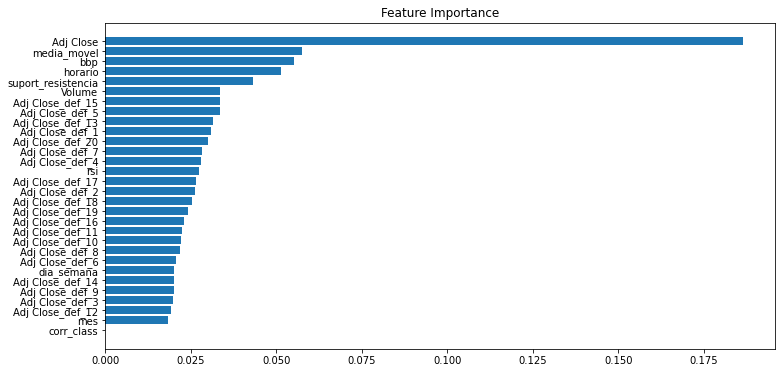

In [63]:
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X1_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [49]:
import time

#### Otimização de Hiperparâmetros

In [64]:
X_train, X_test, y_train, y_test = preprocessamento(base_cop, base_cop.index[round(len(base_cop.index) * 0.8)], 'target_fut')
# otimização para XGBoost undersampled
xgb = XGBClassifier(random_state=42)
parametros_xgb = {
    'n_estimators': range(50,250,50),
    'max_depth': range(2,10,2),
    'gamma':[0.1, 0.5, 0.75]}
    
# Obtendo melhores parâmetros e melhor recall para XGBoost
grid_xgb = GridSearchCV(estimator = xgb,
                        param_grid = parametros_xgb,
                        cv=5,
                        scoring = 'f1_weighted')
grid_xgb.fit(X_train[-600:], y_train[-600:]) # somente a melhor qtd encontrada
xgb_over_best_params = grid_xgb.best_params_
xgb_over_best_score = grid_xgb.best_score_
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

{'gamma': 0.75, 'max_depth': 2, 'n_estimators': 50}
0.7491461377902343


### MEUS MODELOS

### naive bayes

In [28]:
modelo = GaussianNB()
modelo.fit(x_train, y_train)
previsoes = modelo.predict(x_test)
print('\nClassification Report\n', metrics.classification_report(y_test, previsoes)) 



Classification Report
               precision    recall  f1-score   support

         0.0       0.76      0.71      0.73       180
         1.0       0.69      0.75      0.72       160

    accuracy                           0.73       340
   macro avg       0.73      0.73      0.73       340
weighted avg       0.73      0.73      0.73       340



### Logistic Regression

In [29]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

y_pred = pd.Series(classifier.predict(x_test))
y_test = y_test.reset_index(drop=True)

print('\nClassification Report\n', metrics.classification_report(y_test, y_pred)) 



Classification Report
               precision    recall  f1-score   support

         0.0       0.78      0.73      0.76       180
         1.0       0.72      0.78      0.74       160

    accuracy                           0.75       340
   macro avg       0.75      0.75      0.75       340
weighted avg       0.75      0.75      0.75       340



### Random Forest Classifiers

In [30]:
# importar o modelo Random Forest Classifier

# treinando o modelo 
classifier = RandomForestClassifier(n_estimators= 21, random_state=42).fit(x_train, y_train);

# aplicando o modelo treinado para a previsão do resultado do teste
predictions3_labels = classifier.predict(x_test)

# Exibindo dataframe com valores 10 reais e suas respectivas previsões
p = pd.DataFrame({'Real': y_test, 'Previsto': predictions3_labels})  
print('\nClassification Report\n', metrics.classification_report(y_test, predictions3_labels)) 



Classification Report
               precision    recall  f1-score   support

         0.0       0.81      0.71      0.75       180
         1.0       0.71      0.81      0.76       160

    accuracy                           0.76       340
   macro avg       0.76      0.76      0.76       340
weighted avg       0.76      0.76      0.76       340



### XGBOOST

In [72]:
# fitando o modelo
xgb = XGBClassifier(random_state=42,max_depth=5) 
#xgb = XGBClassifier(random_state=42, gamma = 0.75, max_depth=2, n_estimators=50)
xgb.fit(x_train, y_train)
y1_pred = xgb.predict(x_test)
print('\nClassification Report\n', metrics.classification_report(y_test, y1_pred)) 



Classification Report
               precision    recall  f1-score   support

         0.0       0.75      0.79      0.77       176
         1.0       0.76      0.72      0.74       166

    accuracy                           0.75       342
   macro avg       0.76      0.75      0.75       342
weighted avg       0.75      0.75      0.75       342



### LGBM

In [32]:
train_data=lgb.Dataset(x_train,label=y_train)

#setting parameters for lightgbm
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

#Here we have set max_depth in xgb and LightGBM to 7 to have a fair comparison between the two.

#training our model using light gbm
num_round=50
start=datetime.now()
lgbm=lgb.train(param,train_data,num_round)
stop=datetime.now()

#Execution time of the model
execution_time_lgbm = stop-start
execution_time_lgbm

#predicting on test set
ypred2=lgbm.predict(x_test)
ypred2[0:5]  # showing first 5 predictions

#converting probabilities into 0 or 1

for i in range(0,len(ypred2)):
    if ypred2[i]>=.5:       # setting threshold to .5
       ypred2[i]=1
    else:  
       ypred2[i]=0
#calculating accuracy

accuracy_lgbm = accuracy_score(ypred2,y_test)
y_test.value_counts()

auc_lgbm = roc_auc_score(y_test,ypred2)
auc_lgbm, accuracy_lgbm

print('\nClassification Report\n', metrics.classification_report(y_test, ypred2)) 



[LightGBM] [Info] Number of positive: 689, number of negative: 678
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5032
[LightGBM] [Info] Number of data points in the train set: 1367, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504023 -> initscore=0.016094
[LightGBM] [Info] Start training from score 0.016094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

### Support Vector Machine SVM

In [33]:
#importar o modelo SVM


# instanciacao e determinacao dos hiperparâmetros do SVM: tipo de kernel
classifier = SVC(kernel='rbf')

# treinando o SVM
classifier.fit(x_train, y_train)

# aplicando o modelo treinado para a previsão da temperatura 
#em todo o conjunto de teste
predictions2_labels = classifier.predict(x_test)

# Exibindo dataframe com valores 10 reais e suas respectivas previsões
p = pd.DataFrame({'Real': y_test, 'Previsto': predictions2_labels})  

print('\nClassification Report\n', metrics.classification_report(y_test, predictions2_labels)) 
 


Classification Report
               precision    recall  f1-score   support

         0.0       0.86      0.59      0.70       180
         1.0       0.66      0.89      0.76       160

    accuracy                           0.74       340
   macro avg       0.76      0.74      0.73       340
weighted avg       0.77      0.74      0.73       340



### ENSAMBLE CLASSIFIER

In [34]:
# Caso não tenha efetuado a normalização/padronização anteriormente
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(x_train)
#X_scaled_test = scaler.transform(x_test)

X_scaled = (x_train)
X_scaled_test = (x_test)

model_sgd = SGDClassifier()
model_svc = SVC()
model_dt = DecisionTreeClassifier()

#SEED = 42
#np.random.seed(SEED)

predict = pd.DataFrame(y_test)
for model in (model_sgd, model_svc, model_dt):
  model.fit(X_scaled, y_train)
  y_pred = model.predict(X_scaled_test)
  predict[model.__class__.__name__] = y_pred

predict

target_fut  SGDClassifier  SVC  DecisionTreeClassifier
0           1.0            0.0  1.0                     0.0
1           0.0            0.0  0.0                     0.0
2           1.0            1.0  1.0                     1.0
3           0.0            0.0  0.0                     0.0
4           1.0            1.0  1.0                     1.0
..          ...            ...  ...                     ...
335         1.0            1.0  1.0                     1.0
336         0.0            0.0  0.0                     0.0
337         1.0            1.0  1.0                     1.0
338         0.0            0.0  0.0                     0.0
339         0.0            0.0  0.0                     0.0

[340 rows x 4 columns]

In [35]:
# utilizando o classificador de votação
#from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators = [('sgd', model_sgd),('svc', model_svc),('dt', model_dt)]
)

predict2 = pd.DataFrame(y_test)
for model in (model_sgd, model_svc, model_dt, voting_clf):
  model.fit(X_scaled, y_train)
  y_pred = model.predict(X_scaled_test)
  predict2[model.__class__.__name__] = y_pred

predict2

target_fut  SGDClassifier  SVC  DecisionTreeClassifier  VotingClassifier
0           1.0            1.0  1.0                     1.0               1.0
1           0.0            0.0  0.0                     0.0               0.0
2           1.0            1.0  1.0                     1.0               1.0
3           0.0            0.0  0.0                     0.0               0.0
4           1.0            1.0  1.0                     1.0               1.0
..          ...            ...  ...                     ...               ...
335         1.0            1.0  1.0                     1.0               1.0
336         0.0            0.0  0.0                     0.0               0.0
337         1.0            1.0  1.0                     1.0               1.0
338         0.0            0.0  0.0                     0.0               0.0
339         0.0            0.0  0.0                     0.0               0.0

[340 rows x 5 columns]

In [36]:
# obtendo as acurácias
model = []
accuracy = []
for clf in (model_sgd, model_svc, model_dt, voting_clf):
  clf.fit(X_scaled, y_train)
  y_pred = clf.predict(X_scaled_test)
  model.append(clf.__class__.__name__)
  accuracy.append(accuracy_score(y_test,y_pred))

col = ['Acurácia']
ac = pd.DataFrame(data=accuracy, index = model,columns=col)
ac

Acurácia
SGDClassifier           0.785294
SVC                     0.735294
DecisionTreeClassifier  0.664706
VotingClassifier        0.747059

#### COMPARAÇÃO DE RESULTADOS

In [87]:
#exemplo para compilar os resultados para uma análise posterior
table = pd.DataFrame(data={
    'scores': ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC'],
    'Logistic Regression': [0.97, 0.09, 0.05, 0.96, 0.77],
    'Decision Tree': [0.90, 0.03, 0.02, 0.94, 0.48],
    'XGBoost': [1.00, 0.86, 0.93, 0.81, 0.89]
})

table.index = table['scores']
table.drop('scores', axis=1, inplace=True)

table
     

Logistic Regression  Decision Tree  XGBoost
scores                                                
Accuracy                  0.97           0.90     1.00
F1 Score                  0.09           0.03     0.86
Precision                 0.05           0.02     0.93
Recall                    0.96           0.94     0.81
AUC                       0.77           0.48     0.89

# REGRESSAO

In [73]:
rx_train, rx_test, ry_train, ry_test = preprocessamento(m_df.iloc[:,:-1], m_df.index[round(len(m_df.index) * 0.8)], 'Adj Close')
rx_train = scaler.fit_transform(rx_train)
rx_test  = scaler.transform(rx_test)

In [38]:
#treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(rx_train, ry_train)
pred= lr.predict(rx_test)
cd =r2_score(ry_test, pred)

f'Coeficiente de determinação (R2):{cd * 100:.2f}'


'Coeficiente de determinação (R2):100.00'

In [41]:
# instanciando o modelo Support Vector Regression
svr = SVR()

# treinando o modelo
svr.fit(rx_train, ry_train)

# prevendo os valores
y_predict = svr.predict(rx_test)
cd_svr = r2_score(ry_test, y_predict)

f'Coeficiente de determinação (R2):{cd_svr * 100:.2f}'


'Coeficiente de determinação (R2):-79.09'

In [42]:
# instanciando o modelo Random Forest Regressor
rfr = RandomForestRegressor(n_estimators= 20, random_state=42).fit(rx_train, ry_train); #n_estimators= 10, random_state=42
pred = rfr.predict(rx_test)
cd_RL = r2_score(ry_test, pred)

f'Coeficiente de determinação (R2):{cd_RL * 100:.2f}'


'Coeficiente de determinação (R2):90.55'

In [74]:
# instanciando o modelo XGBoost Regressor


xgbr = XGBRegressor()
xgbr.fit(rx_train, ry_train)
pred = xgbr.predict(rx_test)

cd_XGBR = r2_score(ry_test, pred)

f'Coeficiente de determinação (R2):{cd_XGBR * 100:.2f}'


'Coeficiente de determinação (R2):68.15'

### ENSEMBLE REGRESSOR

In [53]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [54]:
X_scaled = (rx_train)
X_scaled_test = (rx_test)

In [55]:
# Training regressors
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 =  XGBRegressor(random_state=1) #LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('xbr', reg3)])
ereg = ereg.fit(rx_train, ry_train)

In [56]:
predict2 = pd.DataFrame(ry_test)
for model in (reg1, reg2, reg3, ereg):
  model.fit(X_scaled, ry_train)
  ry_pred = model.predict(X_scaled_test)
  predict2[model.__class__.__name__] = ry_pred

predict2

Adj Close  GradientBoostingRegressor  \
Time                                                              
2023-04-03 22:45:00+00:00  -0.000020                  -0.000034   
2023-04-03 22:46:00+00:00   0.000056                   0.000098   
2023-04-03 22:47:00+00:00  -0.000017                  -0.000031   
2023-04-03 22:48:00+00:00   0.000020                   0.000034   
2023-04-03 22:49:00+00:00   0.000018                   0.000030   
...                              ...                        ...   
2023-04-05 22:54:00+00:00   0.000007                   0.000017   
2023-04-05 22:55:00+00:00   0.000050                   0.000113   
2023-04-05 22:56:00+00:00  -0.000004                  -0.000012   
2023-04-05 22:57:00+00:00   0.000042                   0.000092   
2023-04-05 22:58:00+00:00  -0.000038                  -0.000101   

                           RandomForestRegressor  XGBRegressor  \
Time                                                             
2023-04-03 22:45:00+00:00              -0.000024     -0.000038   
2023-04-03 22:46:00+00:00               0.000056      0.000090   
2023-04-03 22:47:00+00:00              -0.000022     -0.000023   
2023-04-03 22:48:00+00:00               0.000023      0.000036   
2023-04-03 22:49:00+00:00               0.000017      0.000036   
...                                          ...           ...   
2023-04-05 22:54:00+00:00               0.000011      0.000027   
2023-04-05 22:55:00+00:00               0.000069      0.000090   
2023-04-05 22:56:00+00:00              -0.000007     -0.000023   
2023-04-05 22:57:00+00:00               0.000055      0.000090   
2023-04-05 22:58:00+00:00              -0.000057     -0.000075   

                           VotingRegressor  
Time                                        
2023-04-03 22:45:00+00:00        -0.000032  
2023-04-03 22:46:00+00:00         0.000081  
2023-04-03 22:47:00+00:00        -0.000025  
2023-04-03 22:48:00+00:00         0.000031  
2023-04-03 22:49:00+00:00         0.000028  
...                                    ...  
2023-04-05 22:54:00+00:00         0.000018  
2023-04-05 22:55:00+00:00         0.000090  
2023-04-05 22:56:00+00:00        -0.000014  
2023-04-05 22:57:00+00:00         0.000079  
2023-04-05 22:58:00+00:00        -0.000077  

[2864 rows x 5 columns]

In [57]:
# obtendo as métricas R2
model = []
r2 = []
for clf in (reg1, reg2, reg3, ereg):
  clf.fit(X_scaled, ry_train)
  ry_pred = clf.predict(X_scaled_test)
  model.append(clf.__class__.__name__)
  r2.append(r2_score(ry_test, ry_pred))

col = ['R2']
ac = pd.DataFrame(data=r2, index = model,columns=col)
ac

R2
GradientBoostingRegressor  0.867235
RandomForestRegressor      0.887178
XGBRegressor               0.797363
VotingRegressor            0.866238

## EXPORTANDO O MODELO

In [75]:
ativo = 'EURUSD'

In [76]:
path = 'C:/_PY/Trade_NB/IQOPTION/'

In [77]:
joblib.dump(xgb, path + 'model_'+ ativo +'.pkl')

['C:/_PY/Trade_NB/IQOPTION/model_EURUSD.pkl']

In [78]:
joblib.dump(xgbr, path + 'r_model_'+ ativo +'.pkl')

['C:/_PY/Trade_NB/IQOPTION/r_model_EURUSD.pkl']

## IMPORTANDO O MODELO

In [16]:
path = 'C:/_PY/Trade_NB/IQOPTION/'

In [17]:
model = joblib.load(path + 'model_'+ ativo +'.pkl')

In [18]:
r_model = joblib.load(path + 'r_model_'+ ativo +'.pkl')

### Criando o DATASET conforme o MaxEntradas

In [24]:
time_frame = 7
df_log = np.log(df_base)
ma_log = df_log.rolling(time_frame).mean()
df_sub = (df_log - ma_log).dropna()
#aplicar diferenciação - já joguei direto no m_df ao inves do df_diff
m_df = df_sub.diff(1)
m_df = m_df.dropna()
m_df['return_percent'] = m_df['Adj Close'].pct_change()

# ADD FEATURES
m_df = criar_rsi(m_df) # 'change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi'
m_df = criar_bollinger(m_df) #'upper', 'mid', 'low','bbp'
m_df = suporte_resistencia(m_df) #'suport_resistencia'
m_df = lta_ltb(m_df) # 'corr', 'corr_class'
m_df = media_movel(m_df, 'Adj Close', 20) # 'media_movel'
m_df = feat_temporais(m_df) # 'dia_semana', 'horario', 'mes'

hora_previsao = 1
m_df = target(m_df)
m_df.dropna(inplace=True) #, 'bbp', 'corr_class'
#m_df = m_df[['bbp', 'corr_class','amplitude','body','pavil_call', 'pavil_put', 'retorno_volume', 'retorno','target', 'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
m_df = m_df[['bbp', 'corr_class','target', 'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
m_df = constroi_features_defasadas(m_df,['Adj Close'],20)
m_df = constroi_features_futuras(m_df,'target',hora_previsao)
m_df_model = m_df.drop('target', axis=1)        
#m_df = m_df.dropna() # comentei para que o predict correspondesse ao cndle atual

m_df = m_df.loc[:,['bbp','corr_class', 'target', 
         'Adj Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana',
        'horario', 'mes', 'Adj Close_def_1', 'Adj Close_def_2',
        'Adj Close_def_3', 'Adj Close_def_4', 'Adj Close_def_5',
        'Adj Close_def_6', 'Adj Close_def_7', 'Adj Close_def_8',
        'Adj Close_def_9', 'Adj Close_def_10', 'Adj Close_def_11',
        'Adj Close_def_12', 'Adj Close_def_13', 'Adj Close_def_14',
        'Adj Close_def_15', 'Adj Close_def_16', 'Adj Close_def_17',
        'Adj Close_def_18', 'Adj Close_def_19', 'Adj Close_def_20','target_fut']]        



# NORMALIZAÇÃO
scaler = MinMaxScaler() #StandardScaler()

#classificação
#Pegar o ultimo fechado e candle atual para o predict Classificação:
x_train, X1_test, y_train, y_test = preprocessamento(m_df, m_df.index[round(len(m_df.index) * 0.8)], 'target_fut')
# X1_test = m_df.drop('target_fut', axis=1)[-2:]
X1_test = X1_test[-2:]
scaler.fit(X1_test)
X1_test = scaler.transform(X1_test)
#model.fit(X1_test)
y1_pred = model.predict(X1_test)
y1_proba = model.predict_proba(X1_test)

#regressao
rx_train, X2_test, ry_train, ry_test = preprocessamento(m_df.iloc[:,:-1], m_df.index[round(len(m_df.index) * 0.8)], 'Adj Close')
#X2_test = m_df.drop(['target_fut', 'Adj Close'], axis=1)[-2:]
X2_test = X2_test[-2:]
scaler.fit(X2_test)
X2_test = scaler.transform(X2_test)
y2_pred = r_model.predict(X2_test)
#y2_proba = r_model.predict_proba(X2_test)

tbl_time_0 = m_df.index[-2:][0].strftime('%y-%m-%d %H:%M:%S')
tbl_time_1 = m_df.index[-2:][1].strftime('%y-%m-%d %H:%M:%S')
tbl_regr_0 = y2_pred[0]
tbl_regr_1 = y2_pred[1]
tbl_clas_0 = y1_pred[0]
tbl_clas_1 = y1_pred[1]

In [25]:
print(y1_pred)

[0 1]


In [79]:
print(y1_proba)

[[0.89898264 0.10101735]
 [0.11202919 0.8879708 ]]


In [80]:
print(y1_proba[:, 1][0])

0.10101735


In [34]:
tbl_prob_clas_0 = np.where(tbl_clas_0==0, y1_proba[:, 0][0], y1_proba[:, 1][0])
tbl_prob_clas_1 = np.where(tbl_clas_1==0, y1_proba[:, 0][1], y1_proba[:, 1][1])

In [86]:
np.round(tbl_prob_clas_0, 2)

0.9

In [36]:
tbl_prob_clas_1

array(0.8879708, dtype=float32)

### Classificação - importando o modelo

In [88]:
X_test = m_df.drop('target_fut', axis=1)[-2:]
#st.dataframe(X_test)
#X_train = df[:-1].dropna().drop('target_fut', axis=1)
#y_train = df[:-1].dropna()['target_fut']

X_test = scaler.transform(X_test)
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)
y_proba = y_proba[:, 1]
#y_pred, y_proba = modelo(df, 'target_fut')
print(y_pred, y_proba)


[0. 0.] [1.77310712e-07 5.83476662e-03]


In [89]:
X_test[-2:]

array([[0.7019119 , 1.        , 1.        , 0.46961077, 0.13181475,
        0.56124875, 0.5       , 0.60168174, 1.        , 0.7826087 ,
        0.        , 0.32980499, 0.36887459, 0.4079646 , 0.43655881,
        0.39163869, 0.34184073, 0.3211064 , 0.36857996, 0.42214065,
        0.37945891, 0.44655756, 0.32299879, 0.28873489, 0.25947242,
        0.40124269, 0.35836032, 0.48756654, 0.36284667, 0.40670147,
        0.32409699],
       [0.3877363 , 1.        , 0.        , 0.33790545, 0.68922582,
        0.31286654, 1.        , 0.55956876, 1.        , 0.7826087 ,
        0.        , 0.46961077, 0.32980499, 0.36887459, 0.4079646 ,
        0.43655881, 0.39163869, 0.34184073, 0.3211064 , 0.36857996,
        0.42214065, 0.37945891, 0.44655756, 0.32299879, 0.28873489,
        0.25947242, 0.40124269, 0.35836032, 0.48756654, 0.36284667,
        0.40670147]])

In [51]:
y_pred[0], y_pred[1], round(y_proba[0],2), round(y_proba[1],2)

(0.0, 1.0, 0.02, 0.9)

In [53]:
m_df.index[-2:]

DatetimeIndex(['2022-04-18 17:30:00+00:00', '2022-04-18 18:30:00+00:00'], dtype='datetime64[ns, UTC]', name='Time', freq=None)

In [54]:
m_df.index[-2:][0]

Timestamp('2022-04-18 17:30:00+0000', tz='UTC')

In [55]:
m_df.index[-2:][1]

Timestamp('2022-04-18 18:30:00+0000', tz='UTC')

### Regressao -  importando o modelo

In [68]:
m_df.drop(['target_fut','Adj Close'], axis=1)[-2:]

bbp  corr_class  target    Volume        rsi  \
Time                                                                           
2022-04-18 17:30:00+00:00  1.156603           0       1  0.258228  52.968203   
2022-04-18 18:30:00+00:00  0.191293           0       0 -0.240550  48.622781   

                           suport_resistencia  media_movel  dia_semana  \
Time                                                                     
2022-04-18 17:30:00+00:00                   1     0.000313           0   
2022-04-18 18:30:00+00:00                   2     0.000083           0   

                           horario  mes  ...  Adj Close_def_11  \
Time                                     ...                     
2022-04-18 17:30:00+00:00       17    4  ...         -0.011204   
2022-04-18 18:30:00+00:00       18    4  ...         -0.000089   

                           Adj Close_def_12  Adj Close_def_13  \
Time                                                            
2022-04-18 17:30:00+00:00         -0.004678         -0.000071   
2022-04-18 18:30:00+00:00         -0.011204         -0.004678   

                           Adj Close_def_14  Adj Close_def_15  \
Time                                                            
2022-04-18 17:30:00+00:00         -0.004481         -0.001364   
2022-04-18 18:30:00+00:00         -0.000071         -0.004481   

                           Adj Close_def_16  Adj Close_def_17  \
Time                                                            
2022-04-18 17:30:00+00:00          0.002232          0.005396   
2022-04-18 18:30:00+00:00         -0.001364          0.002232   

                           Adj Close_def_18  Adj Close_def_19  \
Time                                                            
2022-04-18 17:30:00+00:00          0.006991          0.001573   
2022-04-18 18:30:00+00:00          0.005396          0.006991   

                           Adj Close_def_20  
Time                                         
2022-04-18 17:30:00+00:00          0.000233  
2022-04-18 18:30:00+00:00          0.001573  

[2 rows x 30 columns]

In [65]:
X2_test = m_df.drop(['target_fut','Adj Close'], axis=1)[-2:]
#st.dataframe(X_test)
#X_train = df[:-1].dropna().drop('target_fut', axis=1)
#y_train = df[:-1].dropna()['target_fut']

X2_test = scaler.transform(X2_test)
y2_pred = xgbr.predict(X2_test)
#y2_proba = xgbr.predict_proba(X2_test)
#y2_proba = y2_proba[:, 1]
#y_pred, y_proba = modelo(df, 'target_fut')
print(y2_pred[0],y2_pred[1])


[ 0.00608744 -0.00214058]


In [69]:
print(y2_pred[0],y2_pred[1])

0.0060874354 -0.0021405795


### KNN

### continuação mesclada

### continuação original

In [ ]:
##-----------------------------------slider de horas-------------------------------------------- '''

In [39]:
with col2:
	hora_previsao = st.slider("Tempo Futuro da Previsão (horas)",
				  value=1,
				  min_value=1,
				  max_value=8,
				  step=1)
with col3:
        st.write("Previsão")
with col4:
        st.write("Probabilidade")


In [ ]:
##-----------------------------------VISUALIZAÇÃO DOS DADOS-------------------------------------------- '''

In [40]:
##-----------------------------------slider de horas-------------------------------------------- '''
if st.button('Aperte para Previsão'):
    df_viz = df[-600:]
    st.markdown("")

    # Bollinger Band
    st.subheader('Visualização das features exógenas')
    figBoll = go.Figure()
    figBoll.add_trace(
        go.Scatter(
            x = df_viz.index,
        y = df_viz['upper'],
        name = "Upper Band")
        )
    figBoll.add_trace(
        go.Scatter(
        x = df_viz.index,
        y = df_viz['mid'],
        name = "Média Móvel")
        )
    figBoll.add_trace(
        go.Scatter(
            x = df_viz.index,
        y = df_viz['low'],
        name = "Lower Band")
        )
    figBoll.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1,
        xanchor="left",
        x=0
        ))
    figBoll.update_layout(title_text="Bollinger Band")
    figBoll.update_yaxes(tickprefix="$")
    st.plotly_chart(figBoll, use_container_width=False)

    # Gráfico RSI
    fig = px.line(df_viz, x=df_viz.index, y="rsi")
    fig.update_layout(title_text="Variação de RSI")
    st.plotly_chart(fig, use_container_width=False)
    ##-----------------------------------CRIANDO DATASET-------------------------------------------- '''

    df = target(df)
    df.dropna(inplace=True)
    df = df[['target', 'Adj Close', 'Volume', 'rsi', 'bbp', 'suport_resistencia', 'corr_class', 'media_movel', 'dia_semana', 'horario', 'mes']]
    df = constroi_features_defasadas(df,['Adj Close'],20)
    df = constroi_features_futuras(df,'target',hora_previsao)
    df_model = df.drop('target', axis=1)

    ###-----------------------------------MODELO--------------------------------------------
    if ticker == 'AAPL':
        picklefile = open("stock_pred_AAPL.pkl", "rb")
        model = pickle.load(picklefile)
    if ticker == 'AMZN':
        picklefile = open("stock_pred_AMZN.pkl", "rb")
        model = pickle.load(picklefile)

    df = df_model[-600:]
    #st.dataframe(df)
    X_test = df.drop('target_fut', axis=1)[-1:]
    #st.dataframe(X_test)
    #X_train = df[:-1].dropna().drop('target_fut', axis=1)
    #y_train = df[:-1].dropna()['target_fut']

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    y_proba = y_proba[:, 1]
    #y_pred, y_proba = modelo(df, 'target_fut')

    ###-------------------------------------------------------------------------------------
    with col3:
        #st.write("Previsão")
        if y_proba >= 0.7:
            st.info('Subir ⬆️')
        elif y_proba <= 0.3:
            st.error('Descer ⬇️')
        else:
            st.warning('Na mesma 😐')

    with col4:
        #st.write("Probabilidade")
        #st.subheader(y_proba[0])
        if y_proba >= 0.7:
            st.info(round(y_proba[0],4))
        elif y_proba <= 0.3:
            st.error(round(y_proba[0],4))
        else:
            st.warning(round(y_proba[0],4))